In [1]:
import os
import larq as lq
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.sparsity import keras as sparsity
from tensorflow.keras.layers import Layer
from tensorflow.python.framework import ops
from tensorflow.python.keras import initializers, regularizers, constraints
from tensorflow.python.keras.utils import tf_utils
from tensorflow.python.ops import standard_ops

import templates

In [2]:
# Helper functions
def print_image(image):
  # Squeeze the third dimension or you can use indexing to select the first slice
  image_2d = np.squeeze(image)

  # Plotting the image
  plt.imshow(image_2d, cmap='gray')  # Use the gray colormap for grayscale
  plt.colorbar()  # Optionally add a colorbar to see the intensity scale
  plt.show()

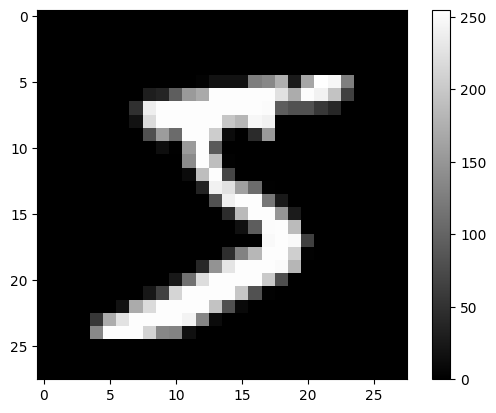

In [3]:
# Prepare dataset
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

train_images = train_images.reshape((60000, 28, 28, 1))
test_images = test_images.reshape((10000, 28, 28, 1))

print_image(train_images[0])
# Normalize pixel values to be between -1 and 1
train_images, test_images = train_images / 127.5 - 1, test_images / 127.5 - 1

In [4]:
class InputShapeCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.input_shapes = []

    def on_epoch_end(self, epoch, logs=None):
        
        for layer in self.model.layers:
            if isinstance(layer, tf.keras.layers.BatchNormalization):
                input_shape = layer.input_shape
                self.input_shapes.append((layer.name, input_shape))
                print(f"Layer: {layer.name}, Input shape: {input_shape}")

In [5]:
# NN Topology

kwargs = dict(input_quantizer="ste_sign",
              kernel_quantizer="ste_sign",
              kernel_constraint="weight_clip")

model = tf.keras.models.Sequential()

input_shape = (28, 28, 1) # Input img shape
filters_a = 32 # Number of output channels
kernel_three = (4, 4) # Kernel dimension

filters_b = 32 # Number of output channels
kernel_b = (3, 3) # Kernel dimension

model.add(lq.layers.QuantConv2D(filters_a, kernel_three,
                                input_quantizer="ste_sign",
                                kernel_quantizer="ste_sign",
                                kernel_constraint="weight_clip",
                                use_bias=False,
                                input_shape=input_shape))
model.add(tf.keras.layers.BatchNormalization(scale=False))
# model.add(tf.keras.layers.MaxPooling2D((2, 2)))

model.add(lq.layers.QuantConv2D(filters_b, kernel_b,
                                input_quantizer="ste_sign",
                                kernel_quantizer="ste_sign",
                                kernel_constraint="weight_clip",
                                use_bias=False,
                                input_shape=input_shape))
model.add(tf.keras.layers.BatchNormalization(scale=False))
# model.add(tf.keras.layers.MaxPooling2D((2, 2)))

model.add(tf.keras.layers.Flatten())
model.add(lq.layers.QuantDense(128, use_bias=False, **kwargs))
model.add(tf.keras.layers.BatchNormalization(scale=False))

model.add(lq.layers.QuantDense(10, use_bias=False, **kwargs))
model.add(tf.keras.layers.BatchNormalization(scale=False))
model.add(tf.keras.layers.Activation("softmax"))
# model.add(tf.keras.layers.Flatten())
# # model.add(lq.layers.QuantDense(500, use_bias=False, **kwargs))
# model.add(lq.layers.QuantDense(10, use_bias=False, **kwargs))
# model.add(tf.keras.layers.Activation("softmax"))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

output_shapes = [layer.output_shape for layer in model.layers]

heights = []
widths = []
channels = []

for shape in output_shapes:
    if len(shape) == 4:  
        _, height, width, channel = shape
        heights.append(height)
        widths.append(width)
        channels.append(channel)
    elif len(shape) == 2:  
        _, channel = shape
        heights.append(None)
        widths.append(None)
        channels.append(channel)

print("Heights:", heights)
print("Widths:", widths)
print("Channels:", channels)



Heights: [25, 25, 23, 23, None, None, None, None, None, None]
Widths: [25, 25, 23, 23, None, None, None, None, None, None]
Channels: [32, 32, 32, 32, 16928, 128, 128, 10, 10, 10]


In [6]:
model.fit(train_images, train_labels, batch_size=64, epochs=6)

conv_weights = []

for layer in model.layers:
    if isinstance(layer, lq.layers.QuantConv2D):
        weights = layer.get_weights()  
        conv_weights.append(weights)


for idx, weights in enumerate(conv_weights):
    print(f"Conv layer {idx + 1} weights shape: {[w.shape for w in weights]}")

Epoch 1/6
938/938 [==============================] - 65s 69ms/step - loss: 0.5600 - accuracy: 0.9360
Epoch 2/6
938/938 [==============================] - 63s 67ms/step - loss: 0.4828 - accuracy: 0.9629
Epoch 3/6
938/938 [==============================] - 64s 69ms/step - loss: 0.4748 - accuracy: 0.9656
Epoch 4/6
938/938 [==============================] - 66s 70ms/step - loss: 0.4677 - accuracy: 0.9687
Epoch 5/6
938/938 [==============================] - 59s 63ms/step - loss: 0.4602 - accuracy: 0.9708
Epoch 6/6
938/938 [==============================] - 57s 61ms/step - loss: 0.4529 - accuracy: 0.9734
Conv layer 1 weights shape: [(4, 4, 1, 32)]
Conv layer 2 weights shape: [(3, 3, 32, 32)]


In [7]:
for idx, weights in enumerate(conv_weights):
    for w in weights:
        print(w)

[[[[-3.65354829e-02  3.42605621e-01  1.11490060e-02  1.90659806e-01
    -5.57024684e-03  4.42363031e-04  5.77575743e-01  3.57662663e-02
     1.66008249e-03  2.06673387e-02 -4.00859630e-03  3.72561932e-01
     1.26805380e-01  2.29202434e-01 -3.90716970e-01 -7.82470524e-01
     6.57926083e-01 -2.27767259e-01  2.35837942e-05 -1.31718710e-01
    -5.82134008e-01  4.44326596e-03  8.30373168e-01 -3.97226587e-02
    -9.59319174e-02 -7.99257606e-02  2.15194672e-01 -9.98528849e-05
    -5.35036623e-01 -1.44872159e-01  1.79196030e-01 -5.67205667e-01]]

  [[ 2.01290916e-03  3.35821033e-01 -3.45111996e-01  1.52577519e-01
     9.10715833e-02 -3.10630262e-01  7.79323339e-01 -1.11269005e-01
     7.17715383e-01  6.89680129e-02 -4.67170812e-02  3.56150836e-01
    -3.03895853e-04 -1.61509216e-02 -3.23024299e-03 -9.99746561e-01
     2.47470453e-01 -2.08936427e-02 -7.18478113e-03 -1.68663971e-02
    -2.53840476e-01 -1.47170484e-01  4.19462293e-01  2.03019828e-02
    -1.46289659e-03 -9.56496000e-02 -2.037041

In [8]:
QD_weights = []
for layer in model.layers:
    if isinstance(layer, lq.layers.QuantDense):
        weights = layer.get_weights()  
        QD_weights.append(weights)

binarized_weights = []
binarized_weight = [np.sign(w) for w in QD_weights]
binarized_weights.append(binarized_weight)

for w in binarized_weights:
    print(w)


[array([[[ 1.,  1.,  1., ..., -1., -1.,  1.],
        [-1.,  1.,  1., ...,  1.,  1., -1.],
        [ 1.,  1., -1., ...,  1., -1.,  1.],
        ...,
        [-1.,  1., -1., ...,  1., -1., -1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [-1., -1., -1., ..., -1., -1.,  1.]]], dtype=float32), array([[[ 1., -1., -1., ..., -1.,  1., -1.],
        [ 1., -1.,  1., ..., -1.,  1.,  1.],
        [ 1., -1., -1., ...,  1., -1.,  1.],
        ...,
        [-1.,  1., -1., ..., -1.,  1.,  1.],
        [-1.,  1., -1., ..., -1., -1.,  1.],
        [ 1., -1.,  1., ..., -1., -1.,  1.]]], dtype=float32)]


In [9]:
# Train NN
test_loss, test_acc = model.evaluate(test_images, test_labels)
lq.models.summary(model)

313/313 [==============================] - 3s 10ms/step - loss: 1.2364 - accuracy: 0.6926
+sequential stats-----------------------------------------------------------------------------+
| Layer                  Input prec.           Outputs  # 1-bit  # 32-bit  Memory  1-bit MACs |
|                              (bit)                        x 1       x 1    (kB)             |
+---------------------------------------------------------------------------------------------+
| quant_conv2d                     1  (-1, 25, 25, 32)      512         0    0.06      320000 |
| batch_normalization              -  (-1, 25, 25, 32)        0        64    0.25           0 |
| quant_conv2d_1                   1  (-1, 23, 23, 32)     9216         0    1.12     4875264 |
| batch_normalization_1            -  (-1, 23, 23, 32)        0        64    0.25           0 |
| flatten                          -       (-1, 16928)        0         0       0           0 |
| quant_dense                      1         (

In [10]:
# # Extract weights
# with lq.context.quantized_scope(True):
#     weights = model.layers[3].get_weights()
#     print(weights)

#     if len(weights) > 0:
#         weight_array = weights[0] 
#         print("Weights shape:", weight_array.shape)
#     else:
#         print("No weights found in this layer.")

# print(weights[0].shape)
# rows, cols, _, output_channels = weights[0].shape
# print(rows, cols, output_channels)
# for col in range(cols):
#     for row in range(rows):
#         for output_channel in range(output_channels):
#             print(row, col, output_channel, weights[0][row][col][0][output_channel])

# for layer in model.layers:
#     if isinstance(layer, tf.keras.layers.BatchNormalization):
#         beta, moving_mean, moving_variance = layer.get_weights()
#         print(f"Layer: {layer.name}")
#         print(f"  Beta (offset): {beta}")
#         print(f"Beta Length: {len(beta)}")
#         print(f"  Moving Mean: {moving_mean}")
#         print(f" Moving Mean Length: {len(moving_mean)}")
#         print(f"  Moving Variance: {moving_variance}")
#         print(f"  Moving Variance Length: {len(moving_variance)}")

In [11]:
input_shape_callback = InputShapeCallback()

for layer in model.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        input_shape = layer.input_shape
        print(f"Layer: {layer.name}, Input shape: {input_shape}")

Layer: batch_normalization, Input shape: (None, 25, 25, 32)
Layer: batch_normalization_1, Input shape: (None, 23, 23, 32)
Layer: batch_normalization_2, Input shape: (None, 128)
Layer: batch_normalization_3, Input shape: (None, 10)


In [12]:
if not os.path.exists("gen_hdl"):
    os.mkdir("gen_hdl")

# Extract weights
betas = []
moving_means = []
moving_variances = []
for layer in model.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        beta, moving_mean, moving_variance = layer.get_weights()
        betas.append(beta)
        moving_means.append(moving_mean)
        moving_variances.append(moving_variance)

In [13]:
def parse_bn(beta, moving_mean, moving_variance, num: int):

    # thresholds = np.zeros(len(beta))
    compare = ""
    for output_neuron in range(len(beta)):
        # print(len(beta))
        threshold = moving_mean[output_neuron] - beta[output_neuron] * np.sqrt(moving_variance[output_neuron])
        compare += f"   assign o_data[{output_neuron}] = i_data[{output_neuron}] > {threshold} ? 1 : 0;\n"

    output_hdl = templates.BN_TEMPLATE \
        .replace("%DIM_DATA%", str(len(beta))) \
        .replace("%LAYER_NUM%", str(num)) \
        .replace("%COMPARE%", compare)
        
    with open(f"gen_hdl/bn_layer_{num}.v", "w") as f:
        f.write(output_hdl)

In [14]:
for n in range(len(betas)):
    parse_bn(betas[n], moving_means[n], moving_variances[n], n)

weights = model.layers[0].get_weights()
w = weights[0].reshape(16, 1, 32)
print(w.shape)


(16, 1, 32)


In [15]:
class PrunableQuantDense(lq.layers.QuantDense, sparsity.PrunableLayer):
    def get_prunable_weights(self):
        return [self.kernel]

pruning_params = {
    'pruning_schedule': sparsity.PolynomialDecay(
        initial_sparsity=0.0,
        final_sparsity=0.5,
        begin_step=0,
        end_step=len(train_images) // 64 * 6
    )
}

kwargs = dict(input_quantizer="ste_sign",
              kernel_quantizer="ste_sign",
              kernel_constraint="weight_clip")

model_new = tf.keras.models.Sequential()

input_shape = (28, 28, 1)

model_new.add(tf.keras.layers.Flatten(input_shape=input_shape))

# 128 neurons
model_new.add(sparsity.prune_low_magnitude(PrunableQuantDense(128, use_bias=False, **kwargs), **pruning_params))
model_new.add(tf.keras.layers.BatchNormalization(scale=False))

# 128 neurons
model_new.add(sparsity.prune_low_magnitude(PrunableQuantDense(128, use_bias=False, **kwargs), **pruning_params))
model_new.add(tf.keras.layers.BatchNormalization(scale=False))

# 64 neurons
model_new.add(sparsity.prune_low_magnitude(PrunableQuantDense(64, use_bias=False, **kwargs), **pruning_params))
model_new.add(tf.keras.layers.BatchNormalization(scale=False))

# 10 neurons
model_new.add(sparsity.prune_low_magnitude(PrunableQuantDense(10, use_bias=False, **kwargs), **pruning_params))
model_new.add(tf.keras.layers.BatchNormalization(scale=False))

model_new.add(tf.keras.layers.Activation("softmax"))

model_new.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

model_new.fit(train_images, train_labels,
              batch_size=64, epochs=6,
              callbacks=[sparsity.UpdatePruningStep()])



Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <gast.gast.Expr object at 0x0000022DCA2FE310>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <gast.gast.Expr object at 0x0000022DCA2FE310>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Epoch 1/6
938/938 [==============================] - 6s 4ms/step - loss: 0.8717 - accuracy: 0.8202
Epoch 2/6
938/938 [==============================] - 4s 4ms/step - loss: 0.7025 - accuracy: 0.8741
Epoch 3/6
938/938 [==============================] - 3s 4ms/step - loss: 0.6871 - accuracy: 0.8796
Epoch 4/6
938/938 [==============================] - 3s 4ms/step - loss: 0.6814 - accurac

In [16]:

final_model = tfmot.sparsity.keras.strip_pruning(model_new)
final_model.compile(optimizer='adam',
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])


final_test_loss, final_test_accuracy = final_model.evaluate(test_images, test_labels)
print(f'Stripped Pruned Model Test Loss: {final_test_loss}')
print(f'Stripped Pruned Model Test Accuracy: {final_test_accuracy}')
lq.models.summary(final_model)

313/313 [==============================] - 1s 1ms/step - loss: 0.5945 - accuracy: 0.9041
Stripped Pruned Model Test Loss: 0.5945272445678711
Stripped Pruned Model Test Accuracy: 0.9041000008583069
+sequential_1 stats---------------------------------------------------------------------+
| Layer                   Input prec.    Outputs  # 1-bit  # 32-bit  Memory  1-bit MACs |
|                               (bit)                 x 1       x 1    (kB)             |
+---------------------------------------------------------------------------------------+
| flatten_1                         -  (-1, 784)        0         0       0           0 |
| prunable_quant_dense              1  (-1, 128)   100352         0   12.25      100352 |
| batch_normalization_4             -  (-1, 128)        0       256    1.00           0 |
| prunable_quant_dense_1            1  (-1, 128)    16384         0    2.00       16384 |
| batch_normalization_5             -  (-1, 128)        0       256    1.00        

In [35]:
model_fc = tf.keras.models.Sequential()


input_shape = (28, 28, 1)  


model_fc.add(tf.keras.layers.Flatten(input_shape=input_shape))


model_fc.add(lq.layers.QuantDense(128, use_bias=False, **kwargs))
model_fc.add(tf.keras.layers.BatchNormalization(scale=False))

model_fc.add(lq.layers.QuantDense(128, use_bias=False, **kwargs))
model_fc.add(tf.keras.layers.BatchNormalization(scale=False))

model_fc.add(lq.layers.QuantDense(64, use_bias=False, **kwargs))
model_fc.add(tf.keras.layers.BatchNormalization(scale=False))

model_fc.add(lq.layers.QuantDense(10, use_bias=False, **kwargs))
# model_fc.add(tf.keras.layers.BatchNormalization(scale=False))

model_fc.add(tf.keras.layers.Activation("softmax"))

model_fc.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model_fc.fit(train_images, train_labels, batch_size=64, epochs=6)

model_fc.summary()

Epoch 1/6
938/938 [==============================] - 4s 3ms/step - loss: 1.8514 - accuracy: 0.7731
Epoch 2/6
938/938 [==============================] - 3s 3ms/step - loss: 1.1739 - accuracy: 0.8497
Epoch 3/6
938/938 [==============================] - 3s 3ms/step - loss: 1.0711 - accuracy: 0.8677
Epoch 4/6
938/938 [==============================] - 3s 3ms/step - loss: 0.9749 - accuracy: 0.8790
Epoch 5/6
938/938 [==============================] - 3s 3ms/step - loss: 0.9417 - accuracy: 0.8867
Epoch 6/6
938/938 [==============================] - 3s 3ms/step - loss: 0.9043 - accuracy: 0.8917
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_11 (Flatten)        (None, 784)               0         
                                                                 
 quant_dense_38 (QuantDense  (None, 128)               100352    
 )                                                   

In [36]:
test_loss, test_acc = model_fc.evaluate(test_images, test_labels)
lq.models.summary(model_fc)

313/313 [==============================] - 1s 1ms/step - loss: 0.8969 - accuracy: 0.8922
+sequential_11 stats--------------------------------------------------------------------+
| Layer                   Input prec.    Outputs  # 1-bit  # 32-bit  Memory  1-bit MACs |
|                               (bit)                 x 1       x 1    (kB)             |
+---------------------------------------------------------------------------------------+
| flatten_11                        -  (-1, 784)        0         0       0           0 |
| quant_dense_38                    1  (-1, 128)   100352         0   12.25      100352 |
| batch_normalization_37            -  (-1, 128)        0       256    1.00           0 |
| quant_dense_39                    1  (-1, 128)    16384         0    2.00       16384 |
| batch_normalization_38            -  (-1, 128)        0       256    1.00           0 |
| quant_dense_40                    1   (-1, 64)     8192         0    1.00        8192 |
| batch_nor